# Traveling salesman problem

Find the closed tour that visits all ten cities and has the minimum total length. Distances between pairs of cities are given in the table below:

|         |  ATL  |  ORD  |  DEN  |  IAH  |  LAX  |  MIA  |  JFK  |  SFO  |  SEA  |  DCA  |
|--------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|------:|
|**ATL**  |    0  |  587  | 1212  |  701  | 1936  |  604  |  748  | 2139  | 2182  |  543  |
|**ORD**  |  587  |    0  |  920  |  940  | 1745  | 1188  |  713  | 1858  | 1737  |  597  |
|**DEN**  | 1212  |  920  |    0  |  879  |  831  | 1726  | 1631  |  949  | 1021  | 1494  |
|**IAH**  |  701  |  940  |  879  |    0  | 1379  |  968  | 1420  | 1645  | 1891  | 1220  |
|**LAX**  | 1936  | 1745  |  831  | 1379  |    0  | 2339  | 2451  |  347  |  959  | 2300  |
|**MIA**  |  604  | 1188  | 1726  |  968  | 2339  |    0  | 1092  | 2594  | 2734  |  923  |
|**JFK**  |  748  |  713  | 1631  | 1420  | 2451  | 1092  |    0  | 2571  | 2408  |  205  |
|**SFO**  | 2139  | 1858  |  949  | 1645  |  347  | 2594  | 2571  |    0  |  678  | 2442  |
|**SEA**  | 2182  | 1737  | 1021  | 1891  |  959  | 2734  | 2408  |  678  |    0  | 2329  |
|**DCA**  |  543  |  597  | 1494  | 1220  | 2300  |  923  |  205  | 2442  | 2329  |    0  |

In [1]:
# Define the problem data (cities and costs)
# Run this, then run the final block of this notebook to load the helper functions before continuing
using JuMP, NamedArrays, Cbc

cities = [:ATL, :ORD, :DEN, :IAH, :LAX, :MIA, :JFK, :SFO, :SEA, :DCA]

distances = [     0   587  1212   701  1936   604   748  2139  2182   543
                587     0   920   940  1745  1188   713  1858  1737   597
               1212   920     0   879   831  1726  1631   949  1021  1494
                701   940   879     0  1379   968  1420  1645  1891  1220
               1936  1745   831  1379     0  2339  2451   347   959  2300
                604  1188  1726   968  2339     0  1092  2594  2734   923
                748   713  1631  1420  2451  1092     0  2571  2408   205
               2139  1858   949  1645   347  2594  2571     0   678  2442
               2182  1737  1021  1891   959  2734  2408   678     0  2329
                543   597  1494  1220  2300   923   205  2442  2329     0  ]

c = NamedArray(distances,(cities,cities))
N = size(distances,1);

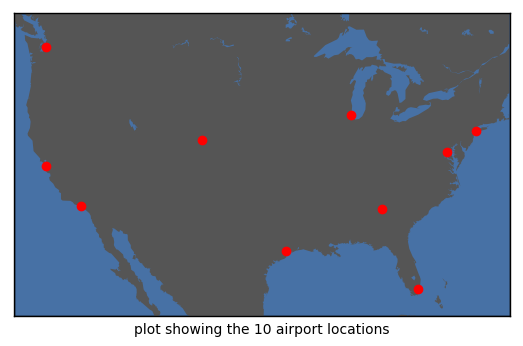

In [3]:
# Run the final block of this notebook to load helper functions before continuing!
mapSolution(0)
xlabel("plot showing the 10 airport locations");

## Solve TSP using min-cost flow relaxation

10×10 Named Array{Int64,2}
A ╲ B │ :ATL  :ORD  :DEN  :IAH  :LAX  :MIA  :JFK  :SFO  :SEA  :DCA
──────┼───────────────────────────────────────────────────────────
:ATL  │    0     0     0     0     0     1     0     0     0     0
:ORD  │    0     0     0     1     0     0     0     0     0     0
:DEN  │    0     0     0     0     0     0     0     0     1     0
:IAH  │    0     1     0     0     0     0     0     0     0     0
:LAX  │    0     0     0     0     0     0     0     1     0     0
:MIA  │    1     0     0     0     0     0     0     0     0     0
:JFK  │    0     0     0     0     0     0     0     0     0     1
:SFO  │    0     0     0     0     1     0     0     0     0     0
:SEA  │    0     0     1     0     0     0     0     0     0     0
:DCA  │    0     0     0     0     0     0     1     0     0     0


5-element Array{Any,1}:
 Symbol[:ATL, :MIA, :ATL]
 Symbol[:ORD, :IAH, :ORD]
 Symbol[:DEN, :SEA, :DEN]
 Symbol[:LAX, :SFO, :LAX]
 Symbol[:JFK, :DCA, :JFK]

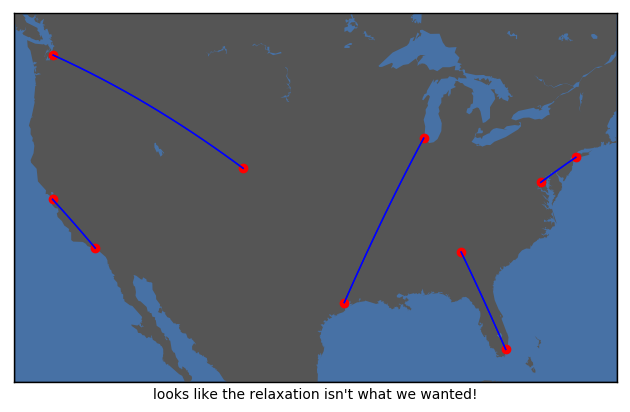

In [4]:
# solve the simplest version (min-cost flow version; it's an assignment problem)

m = Model(solver = CbcSolver())
@variable(m, 0 <= x[cities,cities] <= 1)                                 # LP relaxation
@constraint(m, c1[j in cities], sum( x[i,j] for i in cities ) == 1)    # exacly one edge out of each node
@constraint(m, c2[i in cities], sum( x[i,j] for j in cities ) == 1)    # exactly one edge into each node
@constraint(m, c3[i in cities], x[i,i] == 0 )                       # no self-loops
@objective(m, Min, sum( x[i,j]*c[i,j] for i in cities, j in cities ))  # minimize total cost
solve(m)

# pretty print the solution
xx = getvalue(x)
sol = NamedArray(zeros(Int,N,N),(cities,cities))
for i in cities
    for j in cities
        sol[i,j] = Int(xx[i,j])
    end
end
println(sol)
sleep(1)
display(getAllSubtours(sol))
mapSolution(sol)
xlabel("looks like the relaxation isn't what we wanted!")
tight_layout()
#savefig("tsp_sol_LP.pdf")
;

## Solve TSP using adaptive subtour elimination

In [5]:
m = Model(solver = CbcSolver())
@variable(m, x[cities,cities], Bin)                                       # must formulate as IP this time
@constraint(m, c1[j in cities], sum( x[i,j] for i in cities ) == 1)     # one out-edge
@constraint(m, c2[i in cities], sum( x[i,j] for j in cities ) == 1)     # one in-edge
@constraint(m, c3[i in cities], x[i,i] == 0 )                        # no self-loops
@objective(m, Min, sum( x[i,j]*c[i,j] for i in cities, j in cities ))   # minimize total cost

sols = []

for iters = 1:30
    solve(m)
    println("Tour length: ", getobjectivevalue(m))
    xx = getvalue(x)
    push!(sols,xx)
    subtours = getAllSubtours(xx)  # get all the subtours
    display(subtours)
    sleep(1)
    len = length(subtours)
    if len == 1                    # solution is just a single tour!
        println("SOLVED!")
        break
    else
        for subtour in subtours
            L = length(subtour)
            @constraint(m, sum( x[subtour[k+1],subtour[k]] for k = 1:L-1 ) <= L-2)
            @constraint(m, sum( x[subtour[k],subtour[k+1]] for k = 1:L-1 ) <= L-2)
        end
    end
end

5-element Array{Any,1}:
 Symbol[:ATL, :MIA, :ATL]
 Symbol[:ORD, :IAH, :ORD]
 Symbol[:DEN, :SEA, :DEN]
 Symbol[:LAX, :SFO, :LAX]
 Symbol[:JFK, :DCA, :JFK]

Tour length: 6234.0


3-element Array{Any,1}:
 Symbol[:ATL, :MIA, :IAH, :ATL]      
 Symbol[:ORD, :JFK, :DCA, :ORD]      
 Symbol[:DEN, :SEA, :SFO, :LAX, :DEN]

Tour length: 6665.0


3-element Array{Any,1}:
 Symbol[:ATL, :MIA, :DCA, :JFK, :ORD, :ATL]
 Symbol[:DEN, :IAH, :DEN]                  
 Symbol[:LAX, :SEA, :SFO, :LAX]            

Tour length: 6774.0


3-element Array{Any,1}:
 Symbol[:ATL, :DCA, :JFK, :ORD, :IAH, :MIA, :ATL]
 Symbol[:DEN, :LAX, :DEN]                        
 Symbol[:SFO, :SEA, :SFO]                        

Tour length: 6991.0


3-element Array{Any,1}:
 Symbol[:ATL, :DCA, :JFK, :ORD, :ATL]
 Symbol[:DEN, :SFO, :LAX, :SEA, :DEN]
 Symbol[:IAH, :MIA, :IAH]            

Tour length: 7260.0


1-element Array{Any,1}:
 Symbol[:ATL, :DCA, :JFK, :ORD, :DEN, :SEA, :SFO, :LAX, :IAH, :MIA, :ATL]

Tour length: 7378.0
SOLVED!


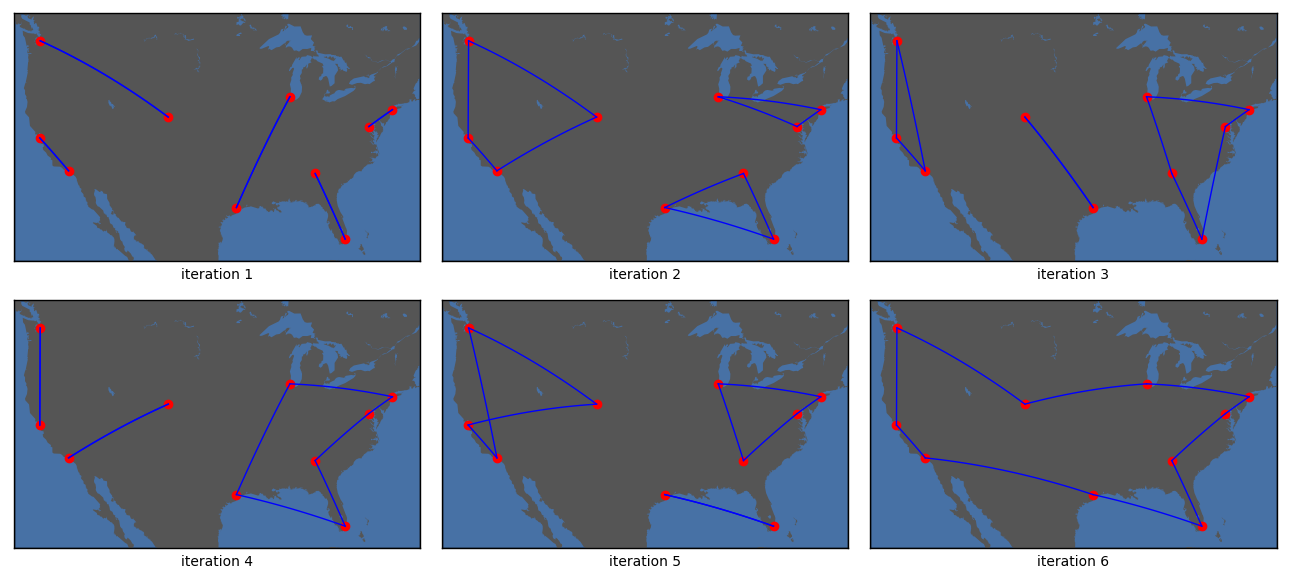

In [6]:
# plot the iterations as we eliminate subtours
figure(figsize=(13,6))
for i = 1:6
    subplot(2,3,i)
    mapSolution(sols[i])
    xlabel(string("iteration ",i))
end
tight_layout()
#savefig("tsp_sol_elim.pdf")

## Miller-Tucker-Zemlin formulation

In [7]:
m = Model(solver = CbcSolver())
@variable(m, x[cities,cities], Bin)                                      # must formulate as IP this time
@constraint(m, c1[j in cities], sum( x[i,j] for i in cities ) == 1)      # one out-edge
@constraint(m, c2[i in cities], sum( x[i,j] for j in cities ) == 1)      # one in-edge
@constraint(m, c3[i in cities], x[i,i] == 0 )                            # no self-loops
@objective(m, Min, sum( x[i,j]*c[i,j] for i in cities, j in cities ))   # minimize total cost
                                    
# MTZ variables and constraints
@variable(m, u[cities])
@constraint(m, c4[i in cities, j in cities[2:end]], u[i] - u[j] + N*x[i,j] <= N-1 )

solve(m)
xx = getvalue(x)
subtours = getAllSubtours(xx)  # get cycle containing Atlanta
display(subtours)
println("Tour length: ", getobjectivevalue(m))

1-element Array{Any,1}:
 Symbol[:ATL, :MIA, :IAH, :LAX, :SFO, :SEA, :DEN, :ORD, :JFK, :DCA, :ATL]

Tour length: 7378.0


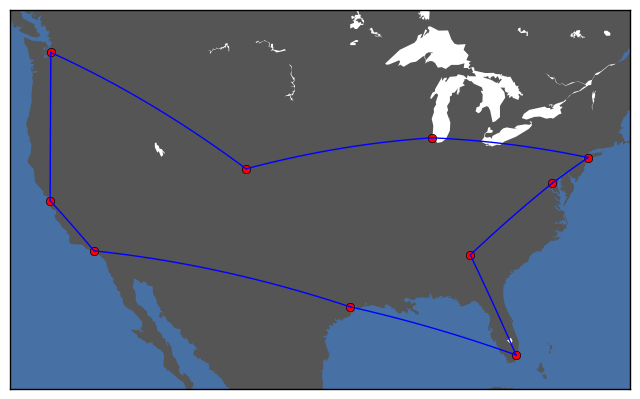

In [24]:
mapSolution(xx)

## Helper functions

### NOTE
I got this to work by following these steps (Windows machine)

~~~~
ENV["PYTHON"]=""        # use Julia-specific python distribution
Pkg.build("PyCall")     # rebuild the PyCall interface
using Conda
Conda.add("mpl_toolkits.basemap")
Conda.update()
~~~~

You can run `Conda.list()` to ensure that you have the correct version of `basemap` installed. It should be version 1.1.0. The reason is that `basemap` depends on `matplotlib`. The latter was updated recently and they deprecated the function `get_axis_bgcolor()`, which breaks `basemap`. The latest version 1.1.0 of `basemap` fixes the issue.

In my case, the steps above only installed 1.0.7. After some looking online, I found out how to get the latest version. First, open a command prompt and navigate to the directory containing the `conda` script. In my case, it was:

`C:\Users\Laurent\AppData\Local\JuliaPro-0.6.2.1\pkgs-0.6.2.1\v0.6\Conda\deps\usr\Scripts`

Then, run the following two commands (each will take a bit of time)

~~~~
conda install -c conda-forge basemap
conda install -c conda-forge basemap-data-hires
~~~~

After this is done, you can return to Julia and check using `Conda.list()` that `basemap` 1.1.0 is installed. Finally, restart the kernel and everything should work.

In [2]:
# HELPER FUNCTION: returns the cycle containing the city START.
function getSubtour(x,start)
    subtour = [start]
    while true
        j = subtour[end]
        for k in cities
            if x[k,j] == 1
                push!(subtour,k)
                break
            end
        end
        if subtour[end] == start
            break
        end
    end
    return subtour
end

# HELPER FUNCTION: returns a list of all cycles
function getAllSubtours(x)
    nodesRemaining = cities
    subtours = []
    while length(nodesRemaining) > 0
        subtour = getSubtour(x,nodesRemaining[1])
        push!(subtours, subtour)
        nodesRemaining = setdiff(nodesRemaining,subtour)
    end
    return subtours
end

# HELPER FUNCTION FOR MAPPING AIRPORTS

data = [ 33.636700  -84.427863 
         41.977320  -87.908005
         39.861667 -104.673166
         29.645417  -95.278888
         33.942437 -118.408121
         25.795361  -80.290110
         40.639926  -73.778694
         37.618806 -122.375416
         47.449889 -122.311777
         38.851444  -77.037721 ]
lat = Dict(zip(cities,data[:,1]))
lon = Dict(zip(cities,data[:,2]))

using PyPlot, PyCall
@pyimport mpl_toolkits.basemap as basemap

function mapSolution(x=0)
    m=basemap.Basemap(projection="merc", resolution="l",llcrnrlat=23,llcrnrlon=-126,urcrnrlat=50,urcrnrlon=-70)
    m[:drawmapboundary](fill_color="#4771a5")
    m[:fillcontinents](color="#555555")

    # plot airports
    for i in cities
        m[:plot](lon[i], lat[i], "ro" ,latlon=true)
    end

    # plot tours
    if x==0
        return
    else
        tours = getAllSubtours(x)
        for t in tours
            L = length(t)-1
            for i in 1:L
                m[:drawgreatcircle](lon[t[i]],lat[t[i]],lon[t[i+1]],lat[t[i+1]],linewidth=1,color="b")
            end
        end
    end
end
;